# Example - Telecom churn prediction

### Introduction

The objective of this example is to develop and validate a **churn model** for a telecom company. The data set is based on a random sample of 7,032 customers. 1,869 of those customers churned during the last month, a **churning rate** of 26.6%. The available data include information about: 

* Customers who left within the last month.

* Services that each customer has signed up for: multiple lines, online security, etc. 

* Customer account information:  how long they've been a customer, contract, payment method, etc.

* Demographic info about customers: gender, age range, etc.

### The data set

The data come in the file `telecom.csv`. The variables included in the data set are:

* `id`, customer's unique ID.

* `gender`, customer's gender (Female/Male).

* `senior_citizen`, a dummy for being more than 60 years of age.

* `partner`, whether the customer has a partner (Yes/No).

* `dependents`, whether the customer has dependents (Yes/No).

* `tenure`, number of months the customer has stayed with the company.

* `phone_service`, whether the customer has a phone service (Yes/No).

* `multiple_lines`, whether the customer has multiple lines (Yes/No/No phone service).

* `internet_service`, customer's internet service provider (DSL/Fiber optic/No).

* `online_security`, whether the customer is signed up for online security (Yes/No/No internet service).

* `online_backup`, whether the customer is signed up for online backup (Yes/No/No internet service).

* `device_protection`, whether the customer is signed up for device protection (Yes/No/No internet service).

* `tech_support`, whether the customer is signed up for technical support (Yes/No/No internet service).

* `streaming_tv`, whether the customer is signed up for streaming TV (Yes/No/No internet service).

* `streaming_movies`, whether the customer is signed up for streaming movies (Yes/No/No internet service).

* `contract`, type of contract (Month-to-month/One year/Two year).

* `paperless_billing`, whether the customer is signed up for paper billing (Yes/No).

* `payment_method`, customer's payment method (Bank transfer/Credit card/Electronic check/Mailed check).

* `monthly_charges`, amount charged to the customer last month, in US dollars.

* `total_charges`, total amount charged to the customer, in US dollars.

* `churn`, whether the customer has churned (Yes/No).

Source: Kaggle.

### Importing the data

I import the data to a **structured NumPy array**, as usual:

In [1]:
import numpy as np
path = 'https://raw.githubusercontent.com/cinnData/MLearning/main/Data/'
fname = path + 'telecom.csv'
data = np.genfromtxt(fname, delimiter=',', names=True, dtype=None, encoding='utf-8')

I also check the data as usual:

In [2]:
data.shape

(7032,)

In [3]:
data[:3]

array([('7590-VHVEG', 'Female', 0, 'Yes', 'No',  1, 'No', 'No phone service', 'DSL', 'No', 'Yes', 'No', 'No', 'No', 'No', 'Month-to-month', 'Yes', 'Electronic check', 29.85,   29.85, 'No'),
       ('5575-GNVDE', 'Male', 0, 'No', 'No', 34, 'Yes', 'No', 'DSL', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'One year', 'No', 'Mailed check', 56.95, 1889.5 , 'No'),
       ('3668-QPYBK', 'Male', 0, 'No', 'No',  2, 'Yes', 'No', 'DSL', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'Month-to-month', 'Yes', 'Mailed check', 53.85,  108.15, 'Yes')],
      dtype=[('id', '<U10'), ('gender', '<U6'), ('senior_citizen', '<i8'), ('partner', '<U3'), ('dependents', '<U3'), ('tenure', '<i8'), ('phone_service', '<U3'), ('multiple_lines', '<U16'), ('internet_service', '<U11'), ('online_security', '<U19'), ('online_backup', '<U19'), ('device_protection', '<U19'), ('tech_support', '<U19'), ('streaming_tv', '<U19'), ('streaming_movies', '<U19'), ('contract', '<U14'), ('paperless_billing', '<U3'), ('payment_method', '<U16'), ('m

Everything looks right. I also check the churning rate:

In [4]:
round(np.mean(data['churn'] == 'Yes'), 3)

0.266

### Target vector and feature matrix

I take the last column of the data set as the **target vector**. I turn it into a dummy, to be consistent with other examples. Note that `data['churn'] == 'Yes'` returns a Boolean 1d array, witth `True` value for the churners. The meaning of `astype` is obvious. 

In [5]:
y = (data['churn'] == 'Yes').astype('int')

Leaving aside the first and the last columns of `data`, I extract separately the numeric and the string features:

In [6]:
X1 = data[['senior_citizen', 'tenure', 'monthly_charges', 'total_charges']]
from numpy.lib.recfunctions import structured_to_unstructured
X1 = structured_to_unstructured(X1)

In [7]:
X2 = data[['gender', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'internet_service',
  'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
  'streaming_movies', 'contract', 'paperless_billing', 'payment_method']]
X2 = structured_to_unstructured(X2)

I turn the columns of `X2` into a collection of dummies. We have seen how to do this in one shot, with a `OneHotEncoder` transformer: 

In [8]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(X2)
X2 = enc.transform(X2).toarray()

Let us check that `X2` is what we expect it to be: 

In [9]:
X2.shape

(7032, 41)

In [10]:
np.unique(X2, return_counts=True)

(array([0., 1.]), array([182832, 105480]))

The numbers match: we have converted 15 features (the original `X2` matrix) with 7,032 observations each, into a collection of 41 dummies, which, in total, contain 7,032 x 15 = 105,480 ones.

To get the final **feature matrix**, we concatenate these two matrices:

In [11]:
X = np.concatenate([X1, X2], axis=1)

### A logistic regression classifier

We train a **logistic regression classifier** on these data: 

In [12]:
from sklearn.linear_model import LogisticRegression
logclf = LogisticRegression(max_iter=500)
logclf.fit(X, y)
round(logclf.score(X, y), 3)

0.804

With the default number of iterations (`max_iter=100`), Python would returning a warning about non-convergence. So I have increased the number of iterations to skip the warning, and, by the way, getting a better-fitting model.

We know that, under **class imbalance** (not severe in this example), it may be a good idea to choose an adequate **cutoff** for the **predictive scores**, and that exploring the distribution of the scores can help to choose the cutoff. The scores are extracted from the class probabilities returned by `predict_proba`:

In [13]:
scores = logclf.predict_proba(X)[:, 1]

Now we plot separate histograms:

In [14]:
from matplotlib import pyplot as plt

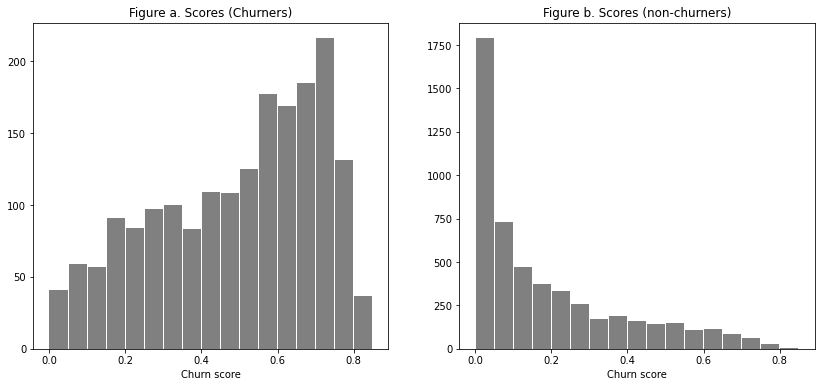

In [15]:
plt.figure(figsize = (14,6))
plt.subplot(1, 2, 1)
plt.hist(scores[y == 1], color='gray', rwidth=0.95, bins=17, range=(0,0.85))
plt.title('Figure a. Scores (Churners)')
plt.xlabel('Churn score')
plt.subplot(1, 2, 2)
plt.hist(scores[y == 0], color='gray', rwidth=0.95, bins=17, range=(0,0.85))
plt.title('Figure b. Scores (non-churners)')
plt.xlabel('Churn score');

The default cutoff 0.5 would not be bad here, because many churners get high scores. 0.3 looks better, so let me try. The confusion matrix is:

In [16]:
ypred = (scores > 0.3).astype('int')
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y, ypred)
conf

array([[3957, 1206],
       [ 429, 1440]])

The true positive and false positive rates:

In [17]:
tp = conf[1, 1]/np.sum(conf[1, :])
fp = conf[0, 1]/np.sum(conf[0, :])
round(tp, 3), round(fp, 3)

(0.77, 0.234)

### Splitting in training and test data sets

In spite of the 23.4% false positive rate, our model is promising, since it can capture 77% of the potential churners. Being a simple model, based on an equation with less than 50 terms, and having more than 7,000 samples, there is not much room for **overfitting**. Anyway, to **validate** the model, I split the data set, at random, in two parts, a **training** set and a **test** set. In scikit-learn, this can be done with the function `train_test_split`, from the subpackage `model_selection`.

In [18]:
from sklearn.model_selection import train_test_split

This function selects the rows at random, returning four arrays: the two parts of the target vector `y` and the two parts of the feature matrix `X`. With the argument `test_size=0.2`, 80% of the samples are used for training the model, keeping the remaining 20% for testing. Note that the split is different every time that the function is applied.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

I retrain the model, but using only the training data:

In [20]:
logclf.fit(X_train, y_train)

LogisticRegression(max_iter=500)

I evaluate the model obtained, first on the training data:

In [21]:
score_train = logclf.predict_proba(X_train)[:, 1]
conf_train = confusion_matrix(y_train, score_train > 0.3)
tp_train = conf_train[1, 1]/sum(conf_train[1, :])
fp_train = conf_train[0, 1]/sum(conf_train[0, :])
round(tp_train, 3), round(fp_train, 3)

(0.743, 0.225)

And then on the test data:

In [22]:
score_test = logclf.predict_proba(X_test)[:, 1]
conf_test = confusion_matrix(y_test, score_test > 0.3)
tp_test = conf_test[1, 1]/sum(conf_test[1, :])
fp_test = conf_test[0, 1]/sum(conf_test[0, :])
round(tp_test, 3), round(fp_test, 3)

(0.769, 0.215)

The performance of the model is similar on the training and the test data. So there is no evidence of overfitting. Since there is a random part in the process, you will probably feel more comfortable if you try several splits.

### Homework

1. Repeat the validation five times, collecting the true positive and false positive rates, and checking the variation among them.

2. Develop a decision tree classifier for these data and validate it. Is it better than the logistic regression classifier presented in this example? 